## Note
Version 2와 다른 점
- V2은 낚시성 영상과 비낚시성 영상의 자막 + 낚시성 기사와 비낚시성 기사를 동시에 학습함
- V3는 V2의 Underfitting과 Overfitting 개선과 성능 최적화
- Google Cloud Platform의 Tesla V100을 활용하여 더 빠르게 학습 가능(아래 ```nvidia-smi``` 확인)

목적
- 도메인 불일치라는 내용을 충분히 학습(기존은 유튜브 영상만 학습하여 도메인 불일치라는 낚시성 영상의 형태를 못 잡아낼 수 있음)
- 학습 데이터에 노이즈 추가
- Over-confidence 방지
- Overfitting/Underfitting 방지

방법
- 마지막 분류 이전에 드롭아웃 계층 추가
- 옵티마이저에 ```weight_decay``` 설정(default:0.01)
- 학습률 스케쥴러 설정

In [27]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sat Jun 15 15:30:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              25W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 0. 라이브러리

In [1]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torchsummary import summary

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

from peft import get_peft_model, LoraConfig, TaskType

In [2]:
# OS 충돌 방지
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Matplotlib 커널 종료 방지
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

fixSEED(seed=42)

In [5]:
# 디렉토리 설정
dir = 'Python_Programs'
path = '/home/leesanghyuk2000/' + dir
os.chdir(path)
print(path)

/home/leesanghyuk2000/Python_Programs


In [6]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1. 데이터 불러오기 및 가공

- 1번 : 유튜브 자막 데이터
- 2번 : AiHub 2000개 데이터

In [7]:
# Load data from a pickle file, and create labels
def callData(path: str):
    with open(path, "rb") as file:
        data = pickle.load(file)

    zero = data[data['label']==0]
    non_zero = data[data['label']==1]

    print(f'레이블 0 개수 : {len(zero)}')
    print(f'레이블 1 개수 : {len(non_zero)}')

    return data

In [8]:
# load data
aihub_data = callData("AiHub_Sampled(2000).pkl")

레이블 0 개수 : 990
레이블 1 개수 : 992


In [9]:
# check
aihub_data.head()

,partNum,newsID,newsCategory,newsSubcategory,newsContent,processLevel,processPattern,contentList,sentenceCount,processSentencenum,useType,wordCount,label
270322,P2,PO_M08_568587,정치,외교.안보,한미 외교장관은 13일 윤석열정부 출범 후 첫 회담을 열고 북한의 핵실험 시 강력히...,하,99,[한미 외교장관은 13일 윤석열정부 출범 후 첫 회담을 열고 북한의 핵실험 시 강력...,7,2,0,165,1
230050,P2,SO_M07_673355,사회,전국,과천시 관문실내체육관이 개보수 작업에 들어간다. 개보수에 필요한 예산5700만원을 ...,상,24,"[과천시 관문실내체육관이 개보수 작업에 들어간다., 개보수에 필요한 예산5700만원...",7,2,0,106,1
148500,P2,ET_M03_502000,연예,연예가화제,슈가맨에서 미녀 작사가로 유명한 작사가 김이나가 유희열에게 못생겼다며 굴욕을 줘 화...,하,99,[슈가맨에서 미녀 작사가로 유명한 작사가 김이나가 유희열에게 못생겼다며 굴욕을 줘 ...,7,1,0,123,1
252824,P2,SO_M07_610123,사회,전국,충북도는 삼일절 기념행사에 앞서 오는 2월 28일 오후 충북도청 대회의실에서 3.1...,하,99,[충북도는 삼일절 기념행사에 앞서 오는 2월 28일 오후 충북도청 대회의실에서 3....,7,2,0,138,1
292630,P2,ET_M03_633082,연예,연예가화제,매일 아침마다 시끄러운 알람 소리에도 쉽게 잠이 깨지 않는 사람들을 위한 침대가 발...,중,22,[매일 아침마다 시끄러운 알람 소리에도 쉽게 잠이 깨지 않는 사람들을 위한 침대가 ...,7,4,0,109,1


In [10]:
# 유튜브 데이터 불러오기
youtube_data = callData('youtubeData(8331)_with_label.pkl')

레이블 0 개수 : 5208
레이블 1 개수 : 3123


In [12]:
# concat two data
text1 = aihub_data['newsContent'] # 제목 미포함
text2 = youtube_data['content'] # 제목 미포함

label1 = aihub_data['label']
label2 = youtube_data['label']

data = pd.DataFrame({
    'text': pd.concat([text1, text2], ignore_index=True),
    'label': pd.concat([label1, label2], ignore_index=True)
})

In [14]:
# 레이블 개수 확인
data['label'].value_counts()

label
0    6198
1    4115
Name: count, dtype: int64

### 2. Train/Valid/Test

In [16]:
# Split into Train/Valid/Test
def splitData(data, SEED=42):
    train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['label'])
    train_data, valid_data = train_test_split(train_val_data, test_size=0.25, random_state=SEED, stratify=train_val_data['label'])

    print('학습용 데이터 개수 : {}개 \n검증용 데이터 개수 : {}개 \n평가용 데이터 개수 : {}개'.format(len(train_data), len(valid_data), len(test_data)))
    del train_val_data
    return train_data, valid_data, test_data

In [17]:
train_data, valid_data, test_data = splitData(data)

학습용 데이터 개수 : 6187개 
검증용 데이터 개수 : 2063개 
평가용 데이터 개수 : 2063개


### 3. Dataset 및 Dataloader 정의

In [18]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [24]:
# Dataset for YouTube mixed with AiHub
class MixedDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text'] # 자동생성자막과 기사 본문만
        label = self.data.iloc[idx]['label']

        inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long) # 정수형

### 4. 모델 정의

In [19]:
class BaitingDetectBERT(nn.Module):
    def __init__(self, model_checkpoint, lora_r=8, lora_alpha=1, lora_dropout=0.1):
        super(BaitingDetectBERT, self).__init__()

        # Pre-trained Model
        self.model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

        # LoRA Config
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            target_modules=["query", 'key', "value"],  # Apply LoRA to the attention layers
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout
        )

        # Apply LoRA to Pre-trained Layers
        self.model = get_peft_model(self.model, lora_config)

        # Dropout
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask).logits
        outputs = self.dropout(outputs)
        return outputs

### 5. 학습용 Trainer 정의

In [34]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, precision_metric, recall_metric, f1_metric, device, num_epochs, wait_for_es):
        self.model = model  # model for training
        self.train_dataloader = train_dataloader  # training dataloader
        self.valid_dataloader = valid_dataloader  # validation dataloader
        self.criterion = criterion  # loss function
        self.optimizer = optimizer  # optimizer
        self.acc_metric = acc_metric  # accuracy metric
        self.precision_metric = precision_metric  # precision metric
        self.recall_metric = recall_metric  # recall metric
        self.f1_metric = f1_metric  # f1 score metric
        self.device = device  # device(cuda or cpu)
        self.num_epochs = num_epochs  # number of epochs
        self.wait_for_es = wait_for_es  # early stopping patience

        # 스케줄러 초기화
        total_steps = len(train_dataloader) * num_epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    def train(self):
        train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history = [], [], [], [], []
        valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = [], [], [], [], []

        best_loss = float('inf')
        count = 0
        best_acc = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            print('-' * 100)
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print('-' * 100)

            train_loss, train_acc, train_precision, train_recall, train_f1 = self._train_model()
            valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = self._valid_model()

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            train_precision_history.append(train_precision)
            train_recall_history.append(train_recall)
            train_f1_history.append(train_f1)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            valid_precision_history.append(valid_precision)
            valid_recall_history.append(valid_recall)
            valid_f1_history.append(valid_f1)

            elapsed_time = time.time() - start_time
            print(f'[Train] \t Loss: {train_loss:.4f} \t Acc: {train_acc:.4f} \t Precision: {train_precision:.4f} \t Recall: {train_recall:.4f} \t F1: {train_f1:.4f}')
            print(f'[Valid] \t Loss: {valid_loss:.4f} \t Acc: {valid_acc:.4f} \t Precision: {valid_precision:.4f} \t Recall: {valid_recall:.4f} \t F1: {valid_f1:.4f}')
            print(f'▶️ Epoch {epoch+1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')

            if valid_acc > best_acc:
                best_acc = valid_acc
                try:
                    save_path = f'./YouTube(mixed)_RoBERTa_ACC_{valid_acc:.4f}.pth'
                    torch.save(self.model.state_dict(), save_path)
                    print(f'▶️ Model Saved to {save_path}')
                except Exception as e:
                    print(f'▶️ Model Not Saved: {e}')
                    continue

            if valid_loss < best_loss:
                best_loss = valid_loss
                count = 0
            else:
                count += 1
                if count >= self.wait_for_es:
                    print(f'▶️▶️▶️ Early Stopping at Epoch {epoch+1} ◀️◀️◀️')
                    break

        return train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history

    # Training function
    def _train_model(self):
        self.model.train()

        train_loss = 0
        train_acc = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0

        for batch in tqdm(self.train_dataloader, desc='Training'):
            input_ids, attention_mask, y = batch
            input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

            outputs = self.model(input_ids, attention_mask)
            loss = self.criterion(outputs, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()  # 스케줄러 업데이트

            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += self.acc_metric(preds, y).item()
            train_precision += self.precision_metric(preds, y).item()
            train_recall += self.recall_metric(preds, y).item()
            train_f1 += self.f1_metric(preds, y).item()

        return train_loss / len(self.train_dataloader), train_acc / len(self.train_dataloader), train_precision / len(self.train_dataloader), train_recall / len(self.train_dataloader), train_f1 / len(self.train_dataloader)

    # Validating function
    def _valid_model(self):
        self.model.eval()

        valid_loss = 0
        valid_acc = 0
        valid_precision = 0
        valid_recall = 0
        valid_f1 = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_dataloader, desc='Validating'):
                input_ids, attention_mask, y = batch
                input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, y)

                preds = torch.argmax(outputs, dim=1)
                valid_loss += loss.item()
                valid_acc += self.acc_metric(preds, y).item()
                valid_precision += self.precision_metric(preds, y).item()
                valid_recall += self.recall_metric(preds, y).item()
                valid_f1 += self.f1_metric(preds, y).item()

        return valid_loss / len(self.valid_dataloader), valid_acc / len(self.valid_dataloader), valid_precision / len(self.valid_dataloader), valid_recall / len(self.valid_dataloader), valid_f1 / len(self.valid_dataloader)


### 6. 학습 진행

In [35]:
# 데이터셋 파라미터
batch_size = 32
num_labels = 2
max_length = 128 # V100 사용하기 때문에 128 적용

model_checkpoint = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [36]:
# 데이터셋 정의
train_dataset = MixedDataset(train_data, tokenizer, max_length)
valid_dataset = MixedDataset(valid_data, tokenizer, max_length)
test_dataset = MixedDataset(test_data, tokenizer, max_length)

In [37]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[    0,  4387,  2659,  ...,  3607,  2052,     2],
         [    0, 10442, 27894,  ...,  2359,  2529,     2],
         [    0,   578,  2747,  ...,  8587,  2020,     2],
         ...,
         [    0,  3708,  2052,  ...,  3673,    21,     2],
         [    0,  7579,  7521,  ...,  1378,  4746,     2],
         [    0,  8760,  2062,  ...,  3681,  2200,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
         1, 0, 1, 1, 1, 1, 0, 0])]

In [38]:
# Model
model = BaitingDetectBERT(model_checkpoint)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BaitingDetectBERT(
  (model): PeftModelForSequenceClassification(
    (base_model): LoraModel(
      (model): RobertaForSequenceClassification(
        (roberta): RobertaModel(
          (embeddings): RobertaEmbeddings(
            (word_embeddings): Embedding(32000, 1024, padding_idx=1)
            (position_embeddings): Embedding(514, 1024, padding_idx=1)
            (token_type_embeddings): Embedding(1, 1024)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): RobertaEncoder(
            (layer): ModuleList(
              (0-23): 24 x RobertaLayer(
                (attention): RobertaAttention(
                  (self): RobertaSelfAttention(
                    (query): lora.Linear(
                      (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.1, 

In [39]:
# LoRA 적용 후 훈련 가능한 파라미터 개수
print_trainable_parameters(model)

Trainable Params: 2231298 
All params: 338889732
--------------------------------------------------
Trainable(%): 0.65841


In [45]:
# 학습 파라미터
num_epochs = 20
wait_for_es = 5

learning_rate = 1e-5
weight_decay = 0.3e-3

In [44]:
# 손실함수와 옵티마이저, Metrics, 그리고 학습 스케쥴러
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)

In [46]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  precision_metric,
                  recall_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [47]:
# 학습 시작
train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = trainer.train()

----------------------------------------------------------------------------------------------------
Epoch 1/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:27<00:00,  2.37it/s]


[Train] 	 Loss: 0.6266 	 Acc: 0.6357 	 Precision: 0.5637 	 Recall: 0.2149 	 F1: 0.2923
[Valid] 	 Loss: 0.5715 	 Acc: 0.7614 	 Precision: 0.7678 	 Recall: 0.5952 	 F1: 0.6597
▶️ Epoch 1 complete in 2m 46s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 2/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:26<00:00,  2.41it/s]


[Train] 	 Loss: 0.5393 	 Acc: 0.7460 	 Precision: 0.7492 	 Recall: 0.5501 	 F1: 0.6190
[Valid] 	 Loss: 0.5031 	 Acc: 0.7980 	 Precision: 0.7414 	 Recall: 0.7582 	 F1: 0.7423
▶️ Epoch 2 complete in 5m 32s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 3/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:27<00:00,  2.40it/s]


[Train] 	 Loss: 0.4838 	 Acc: 0.7892 	 Precision: 0.7689 	 Recall: 0.6831 	 F1: 0.7116
[Valid] 	 Loss: 0.4581 	 Acc: 0.8041 	 Precision: 0.7152 	 Recall: 0.8377 	 F1: 0.7667
▶️ Epoch 3 complete in 8m 18s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 4/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:27<00:00,  2.40it/s]


[Train] 	 Loss: 0.4385 	 Acc: 0.8132 	 Precision: 0.7797 	 Recall: 0.7494 	 F1: 0.7553
[Valid] 	 Loss: 0.4139 	 Acc: 0.8187 	 Precision: 0.7453 	 Recall: 0.8202 	 F1: 0.7749
▶️ Epoch 4 complete in 11m 4s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 5/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:27<00:00,  2.40it/s]


[Train] 	 Loss: 0.4076 	 Acc: 0.8248 	 Precision: 0.7824 	 Recall: 0.7815 	 F1: 0.7732
[Valid] 	 Loss: 0.3930 	 Acc: 0.8163 	 Precision: 0.7338 	 Recall: 0.8462 	 F1: 0.7805
▶️ Epoch 5 complete in 13m 49s
----------------------------------------------------------------------------------------------------
Epoch 6/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:27<00:00,  2.40it/s]


[Train] 	 Loss: 0.3814 	 Acc: 0.8345 	 Precision: 0.7936 	 Recall: 0.7912 	 F1: 0.7847
[Valid] 	 Loss: 0.3663 	 Acc: 0.8336 	 Precision: 0.7750 	 Recall: 0.8167 	 F1: 0.7894
▶️ Epoch 6 complete in 16m 34s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 7/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:26<00:00,  2.41it/s]


[Train] 	 Loss: 0.3674 	 Acc: 0.8327 	 Precision: 0.7971 	 Recall: 0.7825 	 F1: 0.7817
[Valid] 	 Loss: 0.3549 	 Acc: 0.8343 	 Precision: 0.7813 	 Recall: 0.8185 	 F1: 0.7925
▶️ Epoch 7 complete in 19m 21s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 8/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:27<00:00,  2.40it/s]


[Train] 	 Loss: 0.3525 	 Acc: 0.8454 	 Precision: 0.8072 	 Recall: 0.8041 	 F1: 0.7993
[Valid] 	 Loss: 0.3424 	 Acc: 0.8415 	 Precision: 0.8088 	 Recall: 0.7964 	 F1: 0.7961
▶️ Epoch 8 complete in 22m 6s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 9/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:26<00:00,  2.41it/s]


[Train] 	 Loss: 0.3443 	 Acc: 0.8468 	 Precision: 0.8176 	 Recall: 0.7995 	 F1: 0.8013
[Valid] 	 Loss: 0.3350 	 Acc: 0.8446 	 Precision: 0.7941 	 Recall: 0.8249 	 F1: 0.8029
▶️ Epoch 9 complete in 24m 51s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 10/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:27<00:00,  2.40it/s]


[Train] 	 Loss: 0.3332 	 Acc: 0.8547 	 Precision: 0.8228 	 Recall: 0.8127 	 F1: 0.8121
[Valid] 	 Loss: 0.3285 	 Acc: 0.8500 	 Precision: 0.8049 	 Recall: 0.8167 	 F1: 0.8045
▶️ Epoch 10 complete in 27m 37s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 11/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:26<00:00,  2.41it/s]


[Train] 	 Loss: 0.3320 	 Acc: 0.8525 	 Precision: 0.8178 	 Recall: 0.8127 	 F1: 0.8088
[Valid] 	 Loss: 0.3232 	 Acc: 0.8533 	 Precision: 0.8066 	 Recall: 0.8280 	 F1: 0.8119
▶️ Epoch 11 complete in 30m 22s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 12/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:27<00:00,  2.40it/s]


[Train] 	 Loss: 0.3227 	 Acc: 0.8517 	 Precision: 0.8174 	 Recall: 0.7997 	 F1: 0.8026
[Valid] 	 Loss: 0.3208 	 Acc: 0.8528 	 Precision: 0.7986 	 Recall: 0.8417 	 F1: 0.8147
▶️ Epoch 12 complete in 33m 8s
----------------------------------------------------------------------------------------------------
Epoch 13/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:26<00:00,  2.41it/s]


[Train] 	 Loss: 0.3196 	 Acc: 0.8557 	 Precision: 0.8225 	 Recall: 0.8138 	 F1: 0.8117
[Valid] 	 Loss: 0.3180 	 Acc: 0.8553 	 Precision: 0.8188 	 Recall: 0.8235 	 F1: 0.8151
▶️ Epoch 13 complete in 35m 53s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 14/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:27<00:00,  2.41it/s]


[Train] 	 Loss: 0.3172 	 Acc: 0.8589 	 Precision: 0.8287 	 Recall: 0.8094 	 F1: 0.8135
[Valid] 	 Loss: 0.3140 	 Acc: 0.8604 	 Precision: 0.8149 	 Recall: 0.8312 	 F1: 0.8180
▶️ Epoch 14 complete in 38m 38s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 15/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:26<00:00,  2.41it/s]


[Train] 	 Loss: 0.3109 	 Acc: 0.8583 	 Precision: 0.8298 	 Recall: 0.8064 	 F1: 0.8116
[Valid] 	 Loss: 0.3107 	 Acc: 0.8564 	 Precision: 0.8286 	 Recall: 0.8097 	 F1: 0.8138
▶️ Epoch 15 complete in 41m 24s
----------------------------------------------------------------------------------------------------
Epoch 16/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:26<00:00,  2.41it/s]


[Train] 	 Loss: 0.3146 	 Acc: 0.8604 	 Precision: 0.8337 	 Recall: 0.8125 	 F1: 0.8169
[Valid] 	 Loss: 0.3099 	 Acc: 0.8609 	 Precision: 0.8238 	 Recall: 0.8233 	 F1: 0.8164
▶️ Epoch 16 complete in 44m 8s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 17/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:26<00:00,  2.41it/s]


[Train] 	 Loss: 0.3133 	 Acc: 0.8631 	 Precision: 0.8318 	 Recall: 0.8144 	 F1: 0.8168
[Valid] 	 Loss: 0.3079 	 Acc: 0.8609 	 Precision: 0.8284 	 Recall: 0.8222 	 F1: 0.8175
▶️ Epoch 17 complete in 46m 53s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 18/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:26<00:00,  2.41it/s]


[Train] 	 Loss: 0.3134 	 Acc: 0.8587 	 Precision: 0.8253 	 Recall: 0.8204 	 F1: 0.8165
[Valid] 	 Loss: 0.3065 	 Acc: 0.8594 	 Precision: 0.8234 	 Recall: 0.8126 	 F1: 0.8107
▶️ Epoch 18 complete in 49m 39s
----------------------------------------------------------------------------------------------------
Epoch 19/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:27<00:00,  2.40it/s]


[Train] 	 Loss: 0.3118 	 Acc: 0.8625 	 Precision: 0.8379 	 Recall: 0.8161 	 F1: 0.8198
[Valid] 	 Loss: 0.3051 	 Acc: 0.8624 	 Precision: 0.8303 	 Recall: 0.8207 	 F1: 0.8210
▶️ Epoch 19 complete in 52m 24s
▶️ Model Not Saved: Parent directory ./saved_models does not exist.
----------------------------------------------------------------------------------------------------
Epoch 20/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:26<00:00,  2.42it/s]

[Train] 	 Loss: 0.3066 	 Acc: 0.8644 	 Precision: 0.8315 	 Recall: 0.8276 	 F1: 0.8228
[Valid] 	 Loss: 0.3055 	 Acc: 0.8615 	 Precision: 0.8293 	 Recall: 0.8201 	 F1: 0.8190
▶️ Epoch 20 complete in 55m 9s


In [50]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history):
    fig = plt.figure(figsize=(16, 9))

    # Loss Plot
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
    ax1.plot(train_loss_history, label='Train Loss')
    ax1.plot(valid_loss_history, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy Plot
    ax2 = plt.subplot2grid((2, 4), (1, 0))
    ax2.plot(train_acc_history, label='Train Accuracy')
    ax2.plot(valid_acc_history, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Precision Plot
    ax3 = plt.subplot2grid((2, 4), (1, 1))
    ax3.plot(train_precision_history, label='Train Precision')
    ax3.plot(valid_precision_history, label='Validation Precision')
    ax3.set_title('Training and Validation Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend()

    # Recall Plot
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax4.plot(train_recall_history, label='Train Recall')
    ax4.plot(valid_recall_history, label='Validation Recall')
    ax4.set_title('Training and Validation Recall')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Recall')
    ax4.legend()

    # F1 Plot
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    ax5.plot(train_f1_history, label='Train F1 Score')
    ax5.plot(valid_f1_history, label='Validation F1 Score')
    ax5.set_title('Training and Validation F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend()

    plt.tight_layout()
    plt.show()

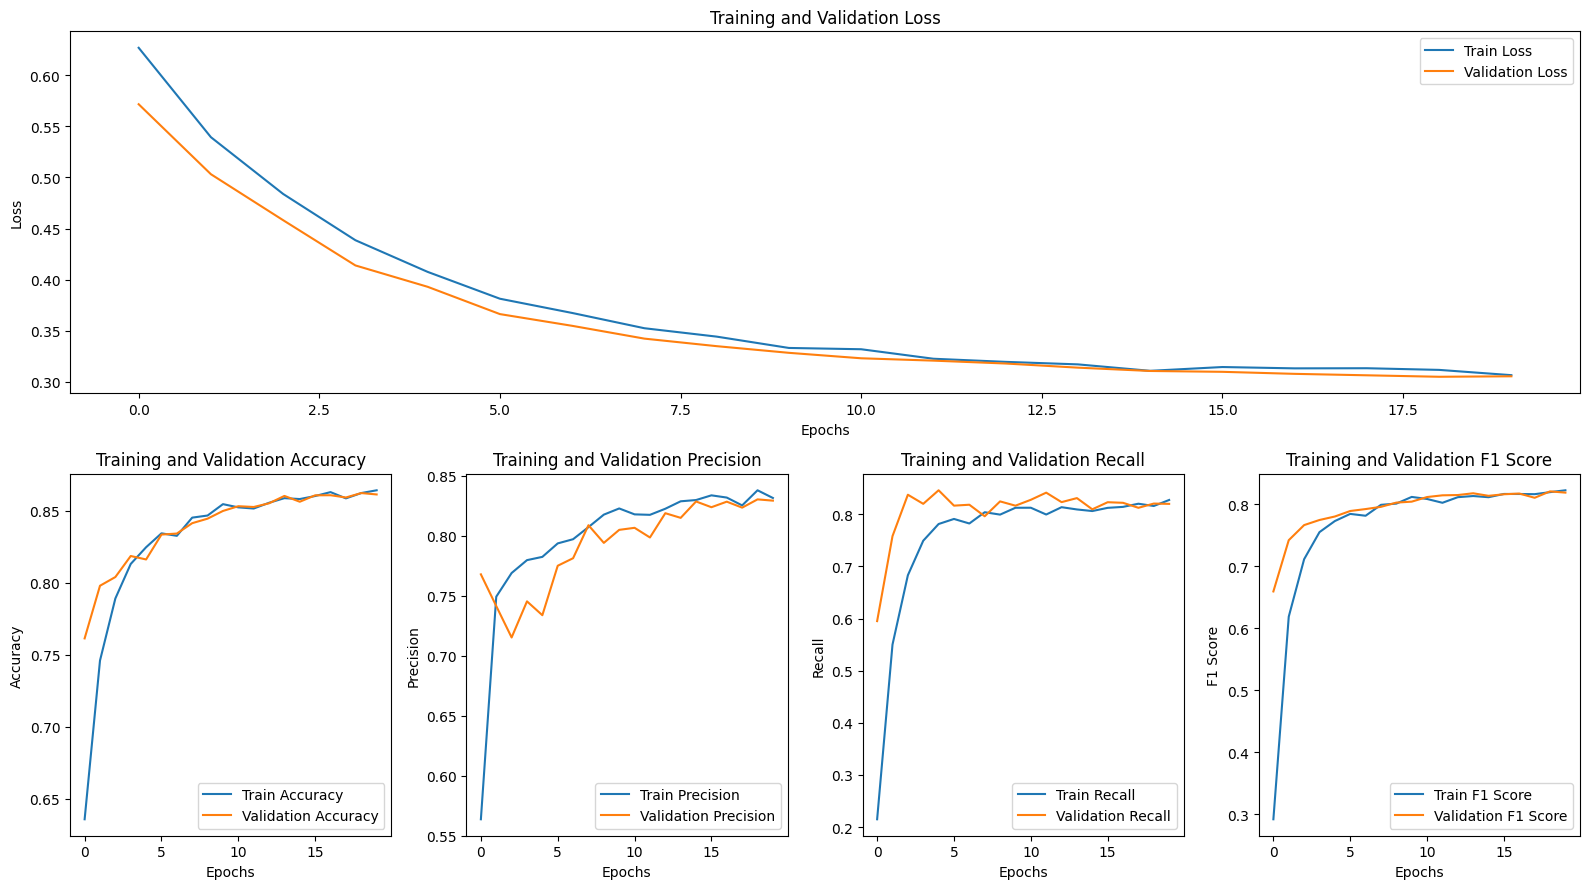

In [51]:
plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history)

In [ ]:
# 모델 로드 함수 정의
def load_model(model_path, model_checkpoint):
    model = BaitingDetectBERT(model_checkpoint)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

# Inference 함수 정의
def inference(model, test_dataloader, device):
    model.eval()

    preds_list = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Testing'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            preds_list.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return preds_list, true_labels

In [ ]:
# 저장된 모델 경로
best_model_path = path+'/saved_models/Youtube/YouTube_RoBERTa_ACC_0.8731.pth'

In [ ]:
# 모델 불러오기
model = load_model(best_model_path, model_checkpoint)

In [ ]:
preds_list, true_labels = inference(model, test_dataloader, device)

In [ ]:
# 평가 지표 계산
test_accuracy = accuracy_score(true_labels, preds_list)
test_f1 = f1_score(true_labels, preds_list)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')